In [1]:
import os,sys,re
import json
import pandas as pd
# import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import drain3
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# import seaborn as sns
import matplotlib
from matplotlib.lines import Line2D
plt.style.use('seaborn-paper')
tex_fonts = {
    "font.family": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.weight":"bold"
}
plt.rcParams.update(tex_fonts)
width = 241.14749
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [3]:
def _json_min_max(path):
    pda =pd.read_json(open(path))
    pda[ "logtime" ] = pd.to_datetime(pda[ "logtime" ])
    pda.sort_values(by='logtime')
    return min(pda[ "logtime" ]), max(pda[ "logtime" ])


jsonpath = os.path.join('/Users/nitrogenousfish/Desktop/ResearchArena/GraphDB/New Experiment/','json')
minlist = []
maxlist = []
for file in os.listdir(jsonpath):
    _ = _json_min_max(os.path.join(jsonpath,file))
    minlist.append(_[0])
    maxlist.append(_[1])
minmin = min(minlist)
maxmax = max(maxlist)

alltime = pd.date_range(minmin,maxmax,freq='S')

In [4]:
def _json_align(path,alltime):
    lenoftime = len(alltime)
    newpd = {
            'mismatch':[0 for i in range(len(alltime))],
            'crash':[0 for i in range(len(alltime))],
            'crash_no_timeout':[0 for i in range(len(alltime))]
        }
    tmpname = ['mismatch','crash','crash_no_timeout']
    pda =pd.read_json(open(path))
    pda[ "logtime" ] = pd.to_datetime(pda[ "logtime" ])
    pda = pda.sort_values(by='logtime')
    pdapos = 0
    for idx in tqdm(range(len(alltime))):
        if pdapos < len(pda):
            if alltime[idx] > pda.iloc[pdapos]['logtime']:
                newpd['mismatch'][idx] = newpd['mismatch'][idx-1]
                newpd['crash'][idx] = newpd['crash'][idx-1]
                newpd['crash_no_timeout'][idx] = newpd['crash_no_timeout'][idx-1]
            if alltime[idx] < pda.iloc[pdapos]['logtime']:
                if idx>0:
                    newpd['mismatch'][idx] = newpd['mismatch'][idx-1]
                    newpd['crash'][idx] = newpd['crash'][idx-1]
                    newpd['crash_no_timeout'][idx] = newpd['crash_no_timeout'][idx-1]
            if alltime[idx] == pda.iloc[pdapos]['logtime']:
                adddict = {
                        'mismatch':0,
                        'crash':0,
                        'crash_no_timeout':0
                }
                while(pdapos<len(pda) and alltime[idx] == pda.iloc[pdapos]['logtime']):
                    ertype = pda.iloc[pdapos]['errortype']
                    if ertype == 'total number reached' or ertype == 'a specific database failed':
                        ...
                    else:
                        adddict[ertype] += 1
                        if ertype == 'crash' and pda.iloc[pdapos]['firstline_causedby'] != 'Timeout':
                            adddict['crash_no_timeout'] += 1
                    pdapos+=1

                if idx>0:
                    newpd['mismatch'][idx] = newpd['mismatch'][idx-1] + adddict['mismatch']
                    newpd['crash'][idx] = newpd['crash'][idx-1] + adddict['crash']
                    newpd['crash_no_timeout'][idx] = newpd['crash_no_timeout'][idx-1] + adddict['crash_no_timeout']
                if idx==0:
                    newpd['mismatch'][0] = adddict['mismatch']
                    newpd['crash'][0] = adddict['crash']
                    newpd['crash_no_timeout'][0] = adddict['crash_no_timeout']
        if pdapos == len(pda):
            if alltime[idx] == pda.iloc[-1]['logtime']:
                adddict = {
                        'mismatch':0,
                        'crash':0,
                        'crash_no_timeout':0
                }
                ertype = pda.iloc[-1]['errortype']
                if ertype == 'total number reached' or ertype == 'a specific database failed':
                    ...
                else:
                    adddict[ertype] += 1
                    if ertype == 'crash' and pda.iloc[-1]['firstline_causedby'] != 'Timeout':
                        adddict['crash_no_timeout'] += 1
                newpd['mismatch'][idx] = newpd['mismatch'][idx-1] + adddict['mismatch']
                newpd['crash'][idx] = newpd['crash'][idx-1] + adddict['crash']
                newpd['crash_no_timeout'][idx] = newpd['crash_no_timeout'][idx-1] + adddict['crash_no_timeout']
            elif alltime[idx] > pda.iloc[-1]['logtime']:
                newpd['mismatch'][idx] = newpd['mismatch'][idx-1]
                newpd['crash'][idx] = newpd['crash'][idx-1]
                newpd['crash_no_timeout'][idx] = newpd['crash_no_timeout'][idx-1]            
            else:
                print('error small')
    return pd.DataFrame(
        {
            'logtime': alltime,
            'mismatch':newpd['mismatch'],
            'crash':newpd['crash'],
            'crash_no_timeout':newpd['crash_no_timeout']
        }
    )

    

In [5]:
_ = os.listdir(jsonpath)
_.sort()
reslist = []
for file in _:
    res = _json_align(os.path.join(jsonpath,file),alltime)
    reslist.append(res)
    print(f"{file}")
    # sns.lineplot(data=res)
    # plt.show()
    # break

100%|██████████| 43202/43202 [00:09<00:00, 4565.79it/s]


_tmp_env_1.json


100%|██████████| 43202/43202 [00:09<00:00, 4623.73it/s]


_tmp_env_2.json


100%|██████████| 43202/43202 [00:09<00:00, 4430.10it/s]

_tmp_env_3.json


In [6]:
totalhour = len(list(reslist[0]['mismatch'][1:-1]))/3600
idx = np.linspace(0,totalhour,len(list(reslist[0]['mismatch'][1:-1])))

In [7]:
finaldata = pd.DataFrame({
    "compared1":list(reslist[0]['mismatch'][1:-1]),
    "compared2":list(reslist[1]['mismatch'][1:-1]),
    "compared3":list(reslist[2]['mismatch'][1:-1])
},index = idx)

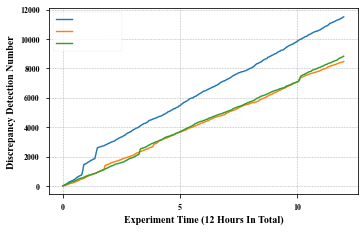

In [8]:
plt.figure(figsize=set_size(400))
plt.xlabel(r'Experiment Time (12 Hours In Total)',fontweight='bold')
plt.ylabel('Discrepancy Detection Number',fontweight='bold',fontsize=10)
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.plot(finaldata['compared3'],  label = 'compared3')
ax.plot(finaldata['compared1'],  label = 'compared1')
ax.plot(finaldata['compared2'],  label = 'compared2')
ax.legend([" "*20 for _ in range(3)])
plt.grid(linestyle = '--', linewidth = 0.5)
plt.savefig('mismatch.svg', format='svg', bbox_inches='tight')

